In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NWP Mini Project/Movie_Titles.csv')
data.head()

,movie_title
0,Black Panther
1,Avengers: Endgame
2,Mission: Impossible -- Fallout
3,Mad Max: Fury Road
4,Spider-Man: Into the Spider-Verse


In [ ]:
print("Number of records: ", data.shape[0])
print("Number of fields: ", data.shape[1])

Number of records:  1610
Number of fields:  1


In [ ]:
data['movie_title'] = data['movie_title'].apply(lambda x: x.replace(u'\xa0',u' '))
data['movie_title'] = data['movie_title'].apply(lambda x: x.replace('\u200a',' '))

## Tokenization

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(data['movie_title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
# print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  1517
Word: ID
------------
<oov>:  1
Strong:  963
And:  5


In [ ]:
input_sequences = []
for line in data['movie_title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  3091


In [ ]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  63, 252],
      dtype=int32)

In [ ]:
max_sequence_len

13

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)


print(xs[5])
print(labels[5])
print(ys[5][14])

[  0   0   0   0   0   0   0   0   0   0 449 254]
255
0.0


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)

checkpoint = ModelCheckpoint("Final_model.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=75, verbose=1, callbacks=[checkpoint])

Epoch 1/75
97/97 [==============================] - ETA: 0s - loss: 6.5406 - accuracy: 0.0925
Epoch 1: loss improved from inf to 6.54061, saving model to Final_model.h5
97/97 [==============================] - 7s 35ms/step - loss: 6.5406 - accuracy: 0.0925
Epoch 2/75
15/97 [===>..........................] - ETA: 0s - loss: 5.3235 - accuracy: 0.1271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - ETA: 0s - loss: 5.1348 - accuracy: 0.1521
Epoch 2: loss improved from 6.54061 to 5.13485, saving model to Final_model.h5
97/97 [==============================] - 1s 10ms/step - loss: 5.1348 - accuracy: 0.1521
Epoch 3/75
97/97 [==============================] - ETA: 0s - loss: 3.7929 - accuracy: 0.3025
Epoch 3: loss improved from 5.13485 to 3.79292, saving model to Final_model.h5
97/97 [==============================] - 1s 10ms/step - loss: 3.7929 - accuracy: 0.3025
Epoch 4/75
92/97 [===========================>..] - ETA: 0s - loss: 2.6334 - accuracy: 0.4755
Epoch 4: loss improved from 3.79292 to 2.64129, saving model to Final_model.h5
97/97 [==============================] - 1s 10ms/step - loss: 2.6413 - accuracy: 0.4749
Epoch 5/75
97/97 [==============================] - ETA: 0s - loss: 1.8839 - accuracy: 0.6024
Epoch 5: loss improved from 2.64129 to 1.88389, saving model to Final_model.h5
97/97 [==============================] - 1s 8ms/step - 

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 100)           151700    
                                                                 
 bidirectional_1 (Bidirecti  (None, 300)               301200    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1517)              456617    
                                                                 
Total params: 909517 (3.47 MB)
Trainable params: 909517 (3.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


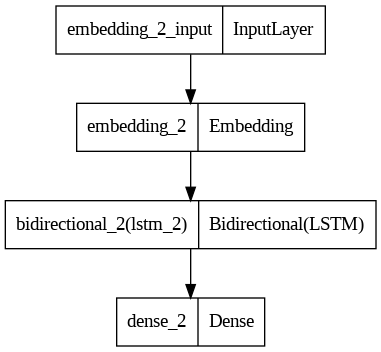

In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

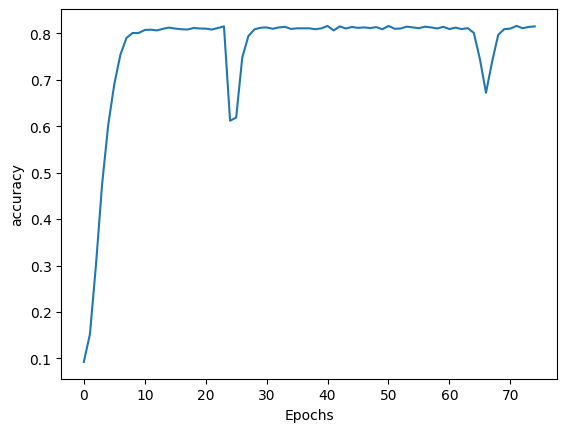

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')

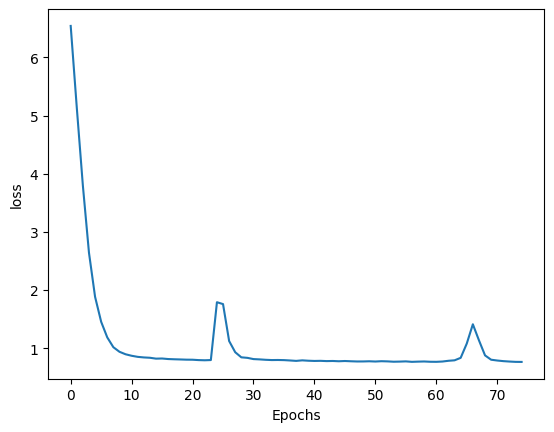

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
seed_text = "kurt"
next_words = 4

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 24ms/step
kurt cobain montage of heck


In [ ]:
# Assuming 'predicted_probs' is the output of model.predict()
predicted_probs = model.predict(token_list, verbose=0)

# Get the top 3 probabilities and their corresponding indices
top_probs_indices = np.argsort(predicted_probs[0])[-3:][::-1]

# Display the top 3 probabilities and corresponding words
for i in top_probs_indices:
    word = tokenizer.index_word[i]
    probability = predicted_probs[0][i]
    print(f'Word: {word}, Probability: {probability}')

Word: heck, Probability: 0.9994014501571655
Word: their, Probability: 0.00010740371362771839
Word: fred, Probability: 9.063251491170377e-05


In [ ]:
!pip install gradio typing-extensions==4.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the saved model
model = load_model('/content/drive/MyDrive/NWP Mini Project/Final_model.h5')

data = pd.read_csv('/content/drive/MyDrive/NWP Mini Project/Movie_Titles.csv')
data['movie_title'] = data['movie_title'].apply(lambda x: x.replace(u'\xa0',u' '))
data['movie_title'] = data['movie_title'].apply(lambda x: x.replace('\u200a',' '))
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(data['movie_title'])
total_words = len(tokenizer.word_index) + 1
input_sequences = []
for line in data['movie_title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    # print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

def generate_text(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text

with gr.Blocks() as demo:
    gr.HTML("<h1><center>Next Word Prediction: Unveiling the Future, One Word at a Time</center></h1>")
    txt = gr.Textbox(label="Your initial word", lines=1)
    slider = gr.Slider(minimum=0, maximum=10, step=1, value=1, label="Number of words")
    txt_3 = gr.Textbox(value="", label="Output")
    btn = gr.Button(value="Submit")
    btn.click(generate_text, inputs=[txt, slider], outputs=[txt_3])


if __name__ == "__main__":
    demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e9edd21627dc05001d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
